In [1]:
import sys
sys.path.append(r'C:\Users\Mechano_2\PycharmProjects\pro')
sys.path

['C:\\Users\\Mechano_2',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\python37.zip',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\DLLs',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final',
 '',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\win32',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Mechano_2\\.ipython',
 'C:\\Users\\Mechano_2\\PycharmProjects\\pro']

In [3]:
import os
import cv2
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mecha.fracture as fracture
import mecha.DIC as dic
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import pickle

In [9]:
#csv파일 형식 바꾸기!

"""setting values"""
path = r'E:\experiment data\aluminum\2021-06-28\3'

slice_x1 = 129
slice_x2 = 213
slice_y1 = 386
slice_y2 = 684
file_list = os.listdir(path+'/img')

result = []
for file in file_list:
    if file.endswith(".jpg"):
        im = cv2.imread(os.path.join(path,'img', file), cv2.IMREAD_GRAYSCALE)
        im_calculate = np.array(im)
        img_box = im_calculate[slice_y1:slice_y2, slice_x1:slice_x2]

        ave = np.average(img_box)
        result = np.append(result, [ave])

result= result - result[0]
print('Finish')
with open(path+'/ml.pkl','wb') as f:
    pickle.dump(result, f)

Finish


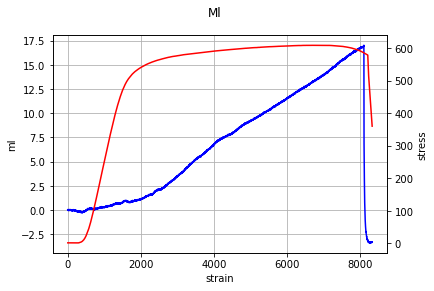

In [10]:
result = pd.read_pickle(path+'/ml.pkl')

ml_avg = np.copy(result)
from scipy.signal import savgol_filter

max_range = 8333
tension_data = np.array(pd.read_csv(path+'/tension.csv', encoding='CP949'))

time, strain, stress = tension_data[:, 0], tension_data[:, 4]*10/25, tension_data[:, 3]*3000/18
# ml_avg[3545:] = ml_avg[3545:] + 1.4
stress = savgol_filter(stress[0:max_range],201,1)
strain = savgol_filter(strain[0:max_range],201,1)
# ml_avg = savgol_filter(ml_avg[0:max_range],2001,1)
ml_avg =  ml_avg[0:max_range]
time = time[0:max_range]

# vline = [600,1800, 3000,3400,7500,8700,9900,11000,12200,13400,15200,16400]
title = 'ml'
fig, ax = plt.subplots()
ax1 = ax.twinx()
# ax1.vlines(vline, 0,600)
fig.suptitle('Ml')
ax.set_xlabel('strain')
ax.set_ylabel('ml')
ax1.set_ylabel('stress')
ax.plot(time, ml_avg, color='b', label="Average Ml(Same mask)")
ax1.plot(time, stress, color='r', label=" stress")
ax.grid()
plt.savefig(path+'/%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)


In [6]:
"""
Matlab코드 여러 Dic데이터있는경우
path = 'E:\experiment data\Epoxy_ml\2021-07-08\0.05\DIC_img\data'

for i=1:1:27
uu=handles_ncorr.data_dic.displacements(i).plot_u_cur_formatted;
vv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
exx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;
eyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;
exy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;

save([path,'/', num2str(i), '_exx', '.mat'],'exx')
save([path,'/', num2str(i), '_exy', '.mat'],'exy')
save([path,'/', num2str(i), '_eyy', '.mat'],'eyy')
save([path,'/', num2str(i), '_uu', '.mat'],'uu')
save([path,'/', num2str(i), '_vv', '.mat'],'vv')

end

"""

"""setting values"""


image = dic.load_file(path+'/DIC_img')

ref = image[list(image.keys())[0]]

In [118]:
ref_xy_list = []
# x_list=np.arange(160,180,5)
# y_list=np.arange(570,770,50)
for xx in x_list:
    for yy in y_list:
        ref_xy_list.append([xx,yy])
ref_xy_list = [[170,725]]

ratio = 1
scale_factor=6

df = pd.DataFrame(columns=['image_name', 'voltage_strain','using_DIC_mask_strain','voltage_stress',
                           'using_DIC_mask_average', 'local_ml', 'local_ee','DIC_exx', 'DIC_eyy', 'DIC_exy','ml_average'])

for ref_x, ref_y in ref_xy_list:
    # for num in [12,,8,9,10,13,14,15,16,17,18,19,20,21,22]:
    for num in range(1,28+1):
        file_num = str(num)
        uu = io.loadmat(path+'/DIC_img/data/'+file_num+'_uu.mat')['uu']
        vv = io.loadmat(path+'/DIC_img/data/'+file_num+'_vv.mat')['vv']
        uu_resize = cv2.resize(uu,(0,0),fx=scale_factor, fy=scale_factor )
        vv_resize = cv2.resize(vv,(0,0),fx=scale_factor, fy=scale_factor )
        exx = io.loadmat(path+'/DIC_img/data/'+file_num+'_exx.mat')['exx']
        eyy = io.loadmat(path+'/DIC_img/data/'+file_num+'_eyy.mat')['eyy']
        exy = io.loadmat(path+'/DIC_img/data/'+file_num+'_exy.mat')['exy']
        ee = fracture.effective_strain(exx, eyy, exy)
        exx_resize = cv2.resize(exx,(0,0),fx=scale_factor, fy=scale_factor )
        eyy_resize = cv2.resize(eyy,(0,0),fx=scale_factor, fy=scale_factor )
        exy_resize = cv2.resize(exy,(0,0),fx=scale_factor, fy=scale_factor )
        ee_resize = cv2.resize(ee,(0,0),fx=scale_factor, fy=scale_factor )

        ee_mask = np.where(ee_resize>0, 255, ee_resize*0).astype('uint8')[1:-1,:]
        ml_image = image[list(image.keys())[num]][:,:,0].astype('float')
        # ml_image = dic.pool2d(ml_image, kernel_size=5, stride=1, pool_mode='max').astype('float')
        ml_image_gas = cv2.GaussianBlur(ml_image,(0,0),10)
        mask_ml = dic.find_zone(cv2.copyTo(ml_image_gas, ee_mask))
        # mask_ml = dic.pool2d(mask_ml, kernel_size=5, stride=1, pool_mode='max').astype('float')
        if num==1:
            zero_ee_mask = ee_mask
        ref_image = image[list(image.keys())[0]][:,:,0].astype('float')
        # ref_image = dic.pool2d(ref_image, kernel_size=5, stride=1, pool_mode='max').astype('float')
        ref_image_gas = cv2.GaussianBlur(ref_image,(0,0),10)
        ref_image_mask = dic.find_zone(cv2.copyTo(ref_image_gas, zero_ee_mask))
        # ref_image_mask = dic.pool2d(ref_image_mask, kernel_size=5, stride=1, pool_mode='max').astype('float')
        cur_y = np.round(ref_y+vv_resize[ref_y,ref_x]/ratio,1).astype('int')
        cur_x = np.round(ref_x+uu_resize[ref_y,ref_x]/ratio,1).astype('int')
        local_ee = np.average(ee_resize[cur_y-8 : cur_y+8 , cur_x-8: cur_x+8])

        dst = cv2.subtract(ml_image[cur_y-8 : cur_y+8 , cur_x-8: cur_x+8],ref_image[ref_y-8 : ref_y+8 , ref_x-8 : ref_x+8])
        local_ml = np.average(cv2.GaussianBlur(dst,(0,0),10))

        image_name = int(list(image.keys())[num].split('_')[1])
        voltage_strain = strain[int(list(image.keys())[num].split('_')[1])]
        voltage_stress = stress[int(list(image.keys())[num].split('_')[1])]
        using_DIC_mask_strain = np.average(dic.find_zone(ee_resize))
        using_DIC_mask_average = np.average(mask_ml)-np.average(ref_image_mask)

        DIC_eyy = np.average(dic.find_zone(eyy))
        DIC_exx = np.average(dic.find_zone(exx))
        DIC_exy = np.average(dic.find_zone(exy))
        ml_average = ml_avg[int(list(image.keys())[num].split('_')[1])]
        row = pd.Series([image_name, voltage_strain,voltage_stress,using_DIC_mask_strain,
                         using_DIC_mask_average, local_ml, local_ee,DIC_exx, DIC_eyy, DIC_exy,ml_average],
                    index=['image_name', 'voltage_strain','voltage_stress','using_DIC_mask_strain',
                           'using_DIC_mask_average', 'local_ml', 'local_ee','DIC_exx', 'DIC_eyy', 'DIC_exy','ml_average'])
        df = df.append(row, ignore_index=True)
        #
        # fig, ax = plt.subplots(1, 3 , constrained_layout=True)
        # fig.suptitle(list(image.keys())[num] + 'strain : ' + str(np.round(strain[int(list(image.keys())[num].split('_')[1])],3)))
        #
        # ax0 = ax[0].imshow(cv2.addWeighted(ml_image,1, ee_mask.astype('float'),0.06,-10),cmap='gray')
        #
        # # ax0 = ax[0].imshow(cv2.addWeighted(ml_image[:,:,2],1, ee_mask,0.06,-10),cmap='gray')
        # ax[0].set_title('ML ROI')
        # # ax[0].scatter(cur_x, cur_y,color='red', marker='s', s=3)
        #
        # ax1 = ax[1].imshow(ee_resize, cmap='jet', vmin=0, vmax=0.25)
        # ax[1].set_title('Effective\n strain')
        # # ax[1].scatter(cur_x, cur_y,color='white', marker='s', s=10)
        # plt.colorbar(ax1,ax=ax[1])
        #
        # gas = cv2.flip(gas,0)
        # ax[2].imshow(gas)
        # ax2 = ax[2].contourf(gas,cmap='jet', vmin=100, vmax=120)
        # ax3 = ax[2].contour(gas,colors='black',linewidths=1)
        # ax[2].invert_yaxis()
        # plt.colorbar(ax2, ax=ax[2])
        # # ax[2].axis('off')
        # ax[2].set_title('ML')
        # # plt.savefig(path+'/'+list(image.keys())[num]+'.png', dpi=300)
        # plt.show()
        # plt.close()

    plt.imshow(ee_resize, cmap='PuBu', vmin=0, vmax=0.25) ##네킹부분 국부
    plt.scatter(cur_x, cur_y, marker='s', s=10  ,label='x:'+str(ref_x) + ' y:'+str(ref_y), edgecolors='black')
    plt.legend()
    plt.legend(loc='center right', bbox_to_anchor=(2.9, 0.5), fancybox=True, shadow=True)
    # plt.savefig(path+'/국부 점으로찍은위치6.png', dpi=300)
    plt.show()
    plt.close()

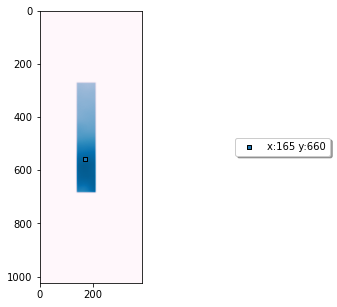

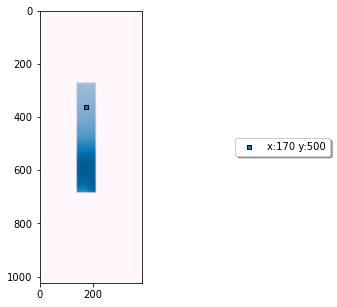

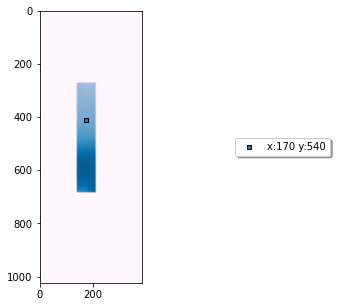

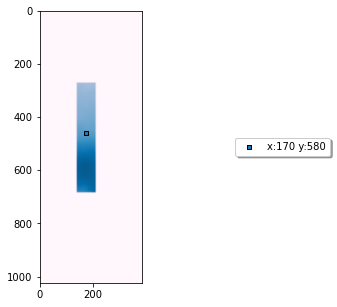

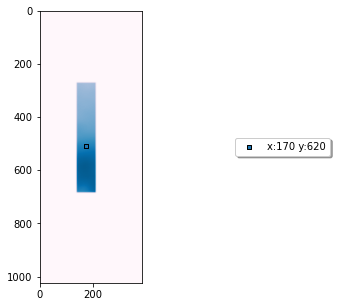

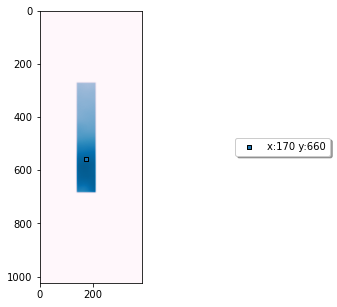

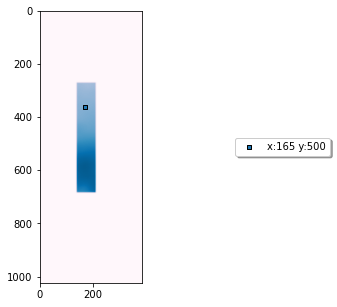

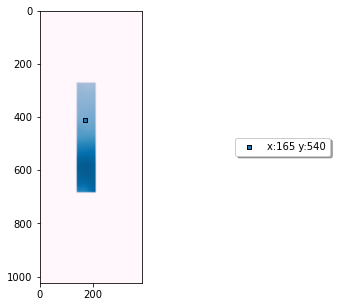

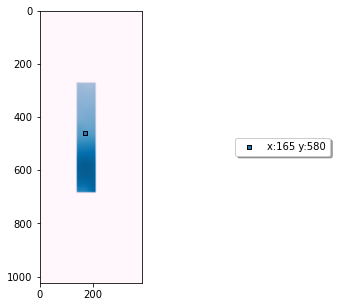

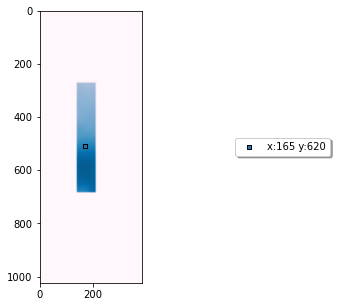

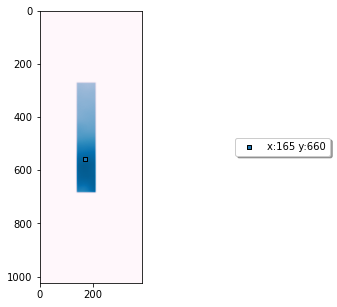

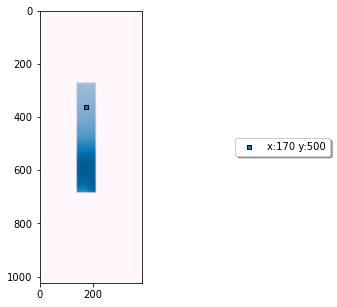

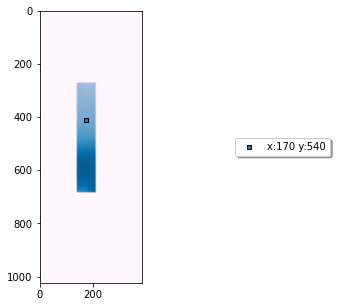

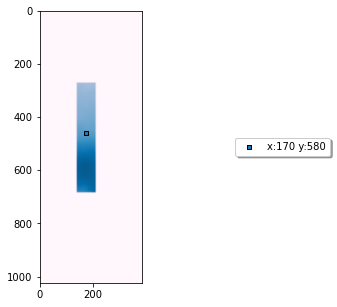

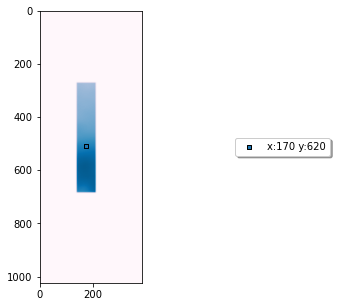

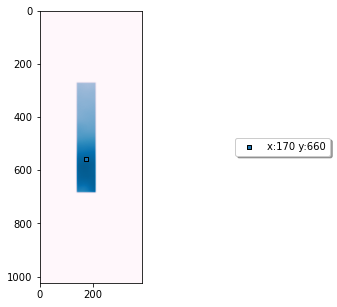

In [126]:
"""최소자승법"""
lms_list = []
for k in range(0,5000):
    i = k*0.1
    lms = np.sum(((i * df.local_ee) - df.local_ml)**2)
    lms_list.append(lms)
np.argmin(lms_list)

plt.rcParams["figure.figsize"] = (5,5)

plt.text(0.085,4.5,'$Ml\,Intensity=%d \,\cdot\, Effective\,strain$'%np.argmin(lms_list), fontsize='10')
plt.scatter(df.using_DIC_mask_strain, df.using_DIC_mask_average, color='red',zorder=1)
plt.plot([0,0.24],[0,0.24*0.1*np.argmin(lms_list)], 'b--',zorder=2)
# plt.plot(df.using_DIC_mask_strain, df.ml_average, color='black')
plt.xlabel('Effective Strain')
plt.ylabel('ML Intensity(AU)')
# plt.grid()
# plt.xlim(0,0.15)
plt.tick_params(direction='in', pad=10,which='both')
plt.minorticks_on()
plt.xlim(0,)
# plt.ylim(0,)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.savefig(path+'/ee_ml.png', dpi=300, bbox_inches='tight',  pad_inches=0)

b = np.vstack((np.arange(0,0.23,0.0005), np.arange(0,0.23,0.0005)*88.5)).transpose()
print(np.argmin(lms_list))
np.savetxt(path+'/effective_strain_ml_파이날.csv',b)

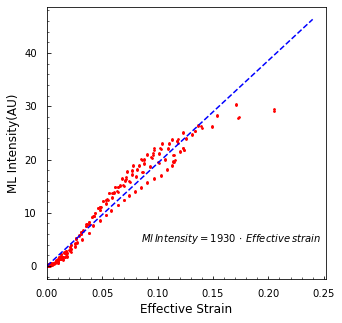

In [127]:
ref_x, ref_y, width, hight = 85,420,40,120
cur_yy = np.round(ref_y+vv_resize[ref_y,ref_x]/ratio,1).astype('int')
cur_xx = np.round(ref_x+uu_resize[ref_y,ref_x]/ratio,1).astype('int')

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=2, ncols=3)
# First axes
ax0 = fig.add_subplot(gs[0:2, 0])
ax0.imshow(image[list(image.keys())[0]],cmap='gray')
# ax0.set_axis_off()
ax0.scatter(ref_x+width/2 , ref_y+hight/2,marker='s', color='black')
ax0.add_patch(
     patches.Rectangle(
        (ref_x, ref_y),
        width,
        hight,
        edgecolor = 'red',
        facecolor = 'black',
        fill=False, lw=3, ls=':'
     ) )
ax3 = fig.add_subplot(gs[0:2, 1])
ax3.imshow(image[list(image.keys())[num]],cmap='gray')
# ax3.set_axis_off()
ax3.scatter(cur_xx+width/2 , cur_yy+hight/2,marker='s', color='black')
ax3.add_patch(
     patches.Rectangle(
        (cur_xx, cur_yy),
        width,
        hight,
        edgecolor = 'red',
        facecolor = 'black',
        fill=False, lw=3, ls=':'
     ) )

ax1 = fig.add_subplot(gs[0,2])
dic = ax1.imshow(ee_resize[cur_yy:cur_yy+hight,cur_xx:cur_xx+width], cmap='jet', vmin=0, vmax=0.25)
# ax1.set_axis_off()
fig.colorbar(dic,ax=ax1)
ax1.scatter(width/2 , hight/2,marker='s', color='black')
ax1.set_title('DIC')


ax2 = fig.add_subplot(gs[1, 2])

gas2 = ml_image[:,:,2][cur_yy:cur_yy+hight,cur_xx:cur_xx+width] - cv2.GaussianBlur(ref_image[:,:,2][ref_y:ref_y+hight,ref_x:ref_x+width],(0,0),15)
# gas2 = cv2.GaussianBlur(ml_image[:,:,2][cur_yy:cur_yy+hight,cur_xx:cur_xx+width],(0,0),15)-90
ax2.scatter(width/2 , hight/2,marker='s', color='black')
ax2.set_title('ML')

ml = ax2.imshow(gas2,cmap='jet',vmin=0,vmax=25)

# ax2.set_axis_off()
fig.colorbar(ml,ax=ax2)



y_ = int(hight/2)
x_ = int(width/2)

print(
    "x,y",ref_x,ref_x+width, ref_y, ref_y+hight,'\n ml:',
    gas2[y_,x_],'\n strain:',
    ee_resize[cur_yy:cur_yy+hight,cur_xx:cur_xx+width][y_,x_],
    "cur,xy",cur_xx,cur_yy
)
plt.savefig(path+'/'+list(image.keys())[num]+'gogo.png', dpi=300,pad_inches=0)
plt.show()
plt.close()


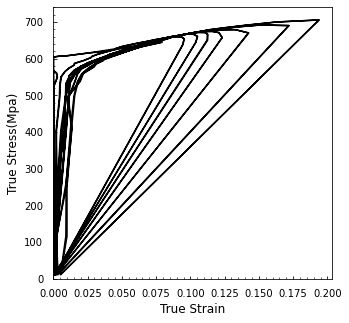

In [100]:
# title = 'Effective strain vs Stress'
plt.tick_params(direction='in', pad=10,which='both')
plt.minorticks_on()
stress, strain = fracture.true_ss(df.voltage_stress, df.local_ee)

stress = np.insert(stress, 0, 0)
strain = np.insert(strain, 0, 0)
plt.plot(strain, stress, color='black')
plt.xlabel('True Strain')
plt.ylabel('True Stress(Mpa)')
# plt.grid()
plt.xlim(0,)
plt.ylim(0,)
plt.savefig(path+'/true_%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)
np.savetxt('truess.csv',np.vstack((strain,stress)).transpose(), delimiter=' ')
plt.show()

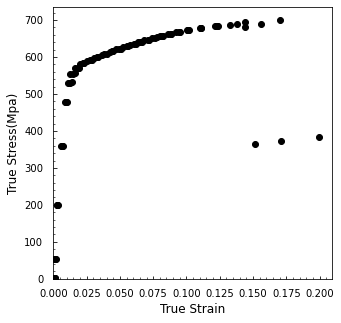

In [115]:
"""수정부분"""


title = 'Effective strain vs Stress'
plt.tick_params(direction='in', pad=10,which='both')
plt.minorticks_on()
true_stress, true_strain = fracture.true_ss(df.voltage_stress, df.local_ee)

# true_stress = np.insert(true_stress, 0, 0)
# true_strain = np.insert(true_strain, 0, 0)
plt.scatter(true_strain, true_stress, color='black')

plt.xlabel('True Strain')
plt.ylabel('True Stress(Mpa)')
# plt.grid()
plt.xlim(0,)
plt.ylim(0,)
plt.savefig(path+'/true_%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)
# np.savetxt('truess.csv',np.vstack((strain,stress)).transpose(), delimiter=' ')
plt.show()

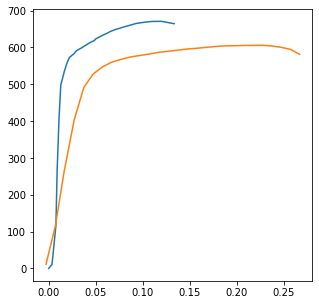

In [46]:
plt.plot(strain, stress)
plt.plot(df.voltage_strain,df.voltage_stress)

In [22]:
ef = pd.read_pickle(r'C:\Users\Mechano_2\PycharmProjects\pro\paper_code_epoxyml/df.pkl')
etrue_stress, etrue_strain = fracture.true_ss(ef.voltage_stress, ef.local_ee)

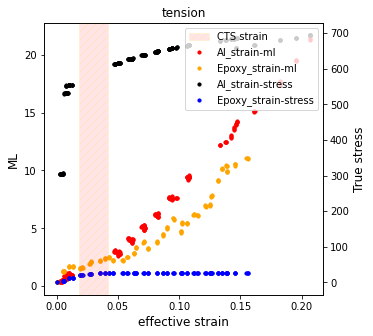

In [83]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.scatter(df.local_ee, df.local_ml, color='red',zorder=1, s = 10)
ax.scatter(ef.local_ee, ef.local_ml, color='orange',zorder=1, s = 10)
ax1.scatter(df.local_ee, true_stress, s = 10, color='black')
ax1.scatter(ef.local_ee, etrue_stress, s = 10, color='blue')
ax.set_ylabel('ML')
ax1.set_ylabel('True stress')
ax.set_xlabel('effective strain')

plt.axvspan(0.018,0.042, facecolor='red', edgecolor='gold',  alpha=0.1, hatch='///', label='CTS strain')
plt.scatter([0],[0],color='red', s=10, label='Al_strain-ml')
plt.scatter([0],[0],color='orange', s=10, label='Epoxy_strain-ml')
plt.scatter([0],[0],color='black', s=10, label='Al_strain-stress')
plt.scatter([0],[0],color='blue', s=10, label='Epoxy_strain-stress')
plt.legend(loc=1)
plt.title('{}'.format(path.split('\\')[-1]))
plt.savefig(path+'/true{}.png'.format(path.split('\\')[-1]), dpi=300, bbox_inches='tight',  pad_inches=0)

,image_name,voltage_strain,using_DIC_mask_strain,voltage_stress,using_DIC_mask_average,local_ml,local_ee,DIC_exx,DIC_eyy,DIC_exy,ml_average
0,301.0,-0.004272,0.001203,1.287510,0.180471,0.157949,0.000860,0.000608,-0.000494,-0.000157,0.124784
1,601.0,0.003118,0.001820,53.532793,0.647268,0.480760,0.001246,-0.000120,0.000542,-0.000109,0.536483
2,901.0,0.013003,0.005629,198.818227,1.172666,1.176678,0.002366,0.000147,0.004598,-0.000054,1.157217
3,1201.0,0.023397,0.005034,357.650837,2.463813,1.961979,0.004262,-0.000701,0.004247,-0.000266,1.870128
4,1501.0,0.033754,0.007625,474.173831,3.217480,2.629972,0.006451,-0.000528,0.007015,-0.000583,2.256282
...,...,...,...,...,...,...,...,...,...,...,...
443,7201.0,0.223633,0.095546,607.628259,21.584497,23.123296,0.116892,-0.060853,0.105315,0.000158,20.323641
444,7501.0,0.233460,0.101609,605.619820,22.467952,24.207553,0.126649,-0.066973,0.111820,0.000271,21.756836
445,7801.0,0.243400,0.117610,600.841266,23.143013,25.063821,0.135919,-0.074842,0.121281,-0.000003,23.336483
446,8101.0,0.253374,0.120692,590.798295,24.018328,25.555581,0.142181,-0.083153,0.132685,0.001212,24.872136


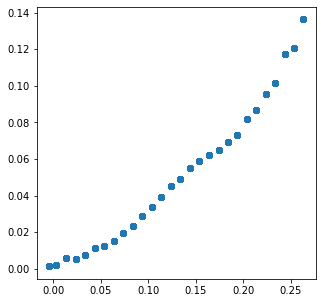

In [113]:
plt.scatter(df.voltage_strain, df.using_DIC_mask_strain)